In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from torch import Tensor, nn
import torch

class ResBlock(nn.Module):
    def __init__(self, channels: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.LeakyReLU(0.01),
            nn.GroupNorm(32, channels),
        )

    def forward(self, x: Tensor) -> Tensor:
        return x + self.net(x)
    
class Downsample(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.01),
            nn.GroupNorm(32, out_channels),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.net(x)
    
class Upsample(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.01),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.net(x)
    
class DownBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.net = nn.Sequential(
            Downsample(in_channels, out_channels),
            ResBlock(out_channels),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.net(x)
    
class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.net = nn.Sequential(
            ResBlock(in_channels),
            Upsample(in_channels, out_channels),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.net(x)

class UnetDenoiser(nn.Module):
    def __init__(self, in_channels: int, start_channels: int, channels_mult: list[int]):
        super().__init__()
        self.num_blocks = len(channels_mult) - 1
        channels = [start_channels * m for m in channels_mult]
        
        self.in_block = nn.Sequential(
            nn.Conv2d(in_channels + 1, channels[0], 3, padding=1),
            nn.LeakyReLU(0.01),
            nn.GroupNorm(32, channels[0]),
            ResBlock(channels[0]),
        )
        self.downs = nn.ModuleList()
        for i in range(self.num_blocks):
            self.downs.append(
                DownBlock(channels[i], channels[i+1]),
            )

        self.ups = nn.ModuleList()
        for i in range(self.num_blocks):
            self.ups.append(
                UpBlock(channels[i+1] * 2 if i != self.num_blocks - 1 else channels[i+1], channels[i]),
            )

        self.out_block = nn.Sequential(
            ResBlock(channels[0] * 2),
            nn.GroupNorm(32, channels[0]* 2),
            nn.LeakyReLU(0.01),
            nn.Conv2d(channels[0]* 2, in_channels, 3, padding=1),
        )
        

    def forward(self, x: Tensor, time_steps: Tensor) -> Tensor:
        '''
        x: (b, c, h, w)
        t: (b)
        '''

        time_steps = time_steps.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).expand(-1, 1, x.shape[2], x.shape[3])
        x = torch.cat([x, time_steps], dim=1)
        x = self.in_block(x) # (b, start_channels, h, w)

        skip_connections = []
        for down in self.downs:
            skip_connections.append(x)
            x = down(x)
            
        for up in reversed(self.ups):
            x = up(x)
            x = torch.cat([x, skip_connections.pop()], dim=1)

        x = self.out_block(x)
        
        return x


In [3]:
from diff_music.binary_diffusion import BinaryDiffusion, BinDiffParams
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
params = BinDiffParams(
    total_steps=64,
    loss_final='weighted',
    use_softmax=True,
    beta_type='linear',
    p_flip=False,
    focal=0.0,
    aux=0.0,
    use_label=False,
    guidance=0.0,
    channels=1,
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
denoizer = UnetDenoiser(1, 64, [1, 2, 4])
diff = BinaryDiffusion(params, denoizer).to(device)
# mnist
ds = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)

Noise scheduler with linear:
Diffusion 1.0 -> 0.5:
1.0000 0.9922 0.9844 0.9766 0.9688 0.9609 0.9531 0.9453 0.9375 0.9297 0.9219 0.9141 0.9062 0.8984 0.8906 0.8828 0.8750 0.8672 0.8594 0.8516 0.8438 0.8359 0.8281 0.8203 0.8125 0.8047 0.7969 0.7891 0.7812 0.7734 0.7656 0.7578 0.7500 0.7422 0.7344 0.7266 0.7188 0.7109 0.7031 0.6953 0.6875 0.6797 0.6719 0.6641 0.6562 0.6484 0.6406 0.6328 0.6250 0.6172 0.6094 0.6016 0.5938 0.5859 0.5781 0.5703 0.5625 0.5547 0.5469 0.5391 0.5312 0.5234 0.5156 0.5078 0.5000
Diffusion 0.0 -> 0.5:
0.0000 0.0078 0.0156 0.0234 0.0312 0.0391 0.0469 0.0547 0.0625 0.0703 0.0781 0.0859 0.0938 0.1016 0.1094 0.1172 0.1250 0.1328 0.1406 0.1484 0.1562 0.1641 0.1719 0.1797 0.1875 0.1953 0.2031 0.2109 0.2188 0.2266 0.2344 0.2422 0.2500 0.2578 0.2656 0.2734 0.2812 0.2891 0.2969 0.3047 0.3125 0.3203 0.3281 0.3359 0.3438 0.3516 0.3594 0.3672 0.3750 0.3828 0.3906 0.3984 0.4062 0.4141 0.4219 0.4297 0.4375 0.4453 0.4531 0.4609 0.4688 0.4766 0.4844 0.4922 0.5000
Beta:
1.0000 0.98

In [4]:
from tqdm import tqdm
dataloader = DataLoader(ds, batch_size=64, shuffle=True)



optim = torch.optim.Adam(denoizer.parameters(), lr=1e-3)

def binarize(x: Tensor) -> Tensor:
    return (x > 0.5).float()

for epoch in range(10):
    progress = tqdm(dataloader)
    for x, _ in progress:
        x = binarize(x.to(device))
        loss = diff(x)['loss']
        optim.zero_grad()
        loss.backward()
        optim.step()
        progress.set_postfix(loss=loss.item())




100%|██████████| 938/938 [00:12<00:00, 75.40it/s, loss=0.0562]


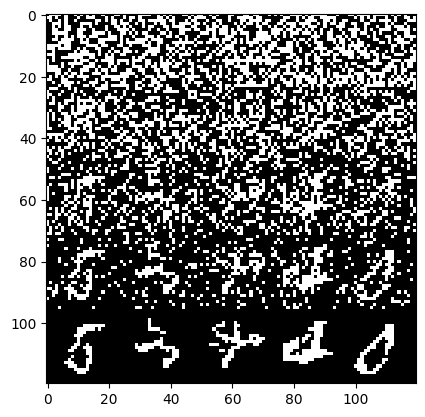

In [30]:
import einops
import matplotlib.pyplot as plt
sampled = diff.sample((5, 1, 24, 24),return_all=True).detach().cpu()
T = sampled.shape[1]
num_display_steps = 4
display_steps = [0] + list(reversed([T -1 - i * (T // num_display_steps) for i in range(num_display_steps)]))

sampled = einops.rearrange(sampled[:,display_steps], 'b t c h w -> (t h) (b w) c')
plt.imshow(sampled.detach().cpu().numpy(), cmap='gray', interpolation='none')

In [30]:
T

65